# Project 2: Web Traffic Analysis
**This is the second of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-11-10, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python**
- **For each question you may use as many cells for your solution as you like**
- **You should document your solution and explain the choices you've made (for example by using multiple cells and use Markdown to assist the reader of the notebook)**
- **You should not remove the problem statements**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**
- **You will be assessed according to correctness and readability of your code, choice of solution, choice of tools and libraries, and documentation of your solution**

## Introduction
In this project your task is to analyze a stream of log entries. A log entry consists of an [IP address](https://en.wikipedia.org/wiki/IP_address) and a [domain name](https://en.wikipedia.org/wiki/Domain_name). For example, a log line may look as follows:

`192.168.0.1 somedomain.dk`

One log line is the result of the event that the domain name was visited by someone having the corresponding IP address. Your task is to analyze the traffic on a number of domains. Counting the number of unique IPs seen on a domain doesn't correspond to the exact number of unique visitors, but it is a good estimate.

Specifically, you should answer the following questions from the stream of log entries.

- How many unique IPs are there in the stream?
- How many unique IPs are there for each domain?
- How many times was IP X seen on domain Y? (for some X and Y provided at run time)

**The answers to these questions can be approximate!**

You should also try to answer one or more of the following, more advanced, questions. The answers to these should also be approximate.

- How many unique IPs are there for the domains $d_1, d_2, \ldots$?
- How many times was IP X seen on domains $d_1, d_2, \ldots$?
- What are the X most frequent IPs in the stream?

You should use algorithms and data structures that you've learned about in the lectures, and you should provide your own implementations of these.

Furthermore, you are expected to:

- Document the accuracy of your answers when using algorithms that give approximate answers
- Argue why you are using certain parameters for your data structures

This notebook is in three parts. In the first part you are given an example of how to read from the stream (which for the purpose of this project is a remote file). In the second part you should implement the algorithms and data structures that you intend to use, and in the last part you should use these for analyzing the stream.

In [45]:
# Install pip packages phmmh3 and scipy in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pymmh3
!{sys.executable} -m pip install scipy

In [6]:
import pymmh3 as mmh3
import math
import urllib
import statistics
import random
import numpy as np
import collections
import pandas as pd
from scipy.integrate import quad
from collections import Counter

## Reading the stream
The following code reads a remote file line by line. It is wrapped in a generator to make it easier to extend. You may modify this if you want to, but your solution should remain parametrized, so that your notebook can be run without having to consume the entire file.

In [7]:
url="https://files.dtu.dk/fss/public/link/public/stream/read/traffic_2?linkToken=_DcyO-U3MjjuNzI-&itemName=traffic_2"

In [11]:
def stream(n):
    i = 0
    with urllib.request.urlopen(url) as f:
        for line in f:
            element = line.rstrip().decode("utf-8")
            yield element
            i += 1
            if i == n:
                break

In [9]:
STREAM_SIZE = 5
web_traffic_stream = stream(STREAM_SIZE)

In [10]:
# test run to print the first 5 lines in the traffic stream
for x in web_traffic_stream:
    print(x)

186.99.192.116	python.org
202.152.82.171	wikipedia.org
130.126.231.205	python.org
116.142.112.214	pandas.pydata.org
113.124.204.127	python.org


## Data structures

### Q1 How many unique IPs are there in the stream?

>There are many implementations available for HyperLogLog. Our group decides to implement the one introduced by Wikipedia. Source : https://en.wikipedia.org/wiki/HyperLogLog.

There are two main differences between the one introduced in lecture and in Wikipedia:

* The hash function. In the lecture slides, the chosen hash function should map variable x to a number in [0, ..., w-1] where w = 32 or 64. In Wikipedia, the chosen hash function can map x to any range of integer.

* The count estimation. In lecture slides, the multiplication of m and the hormonic mean of the array M is returned. However, in Wikipedia, a more sophisticated estimation is presented which results in smaller error in estimation. We have attached a screenshot of the estimation formula below.

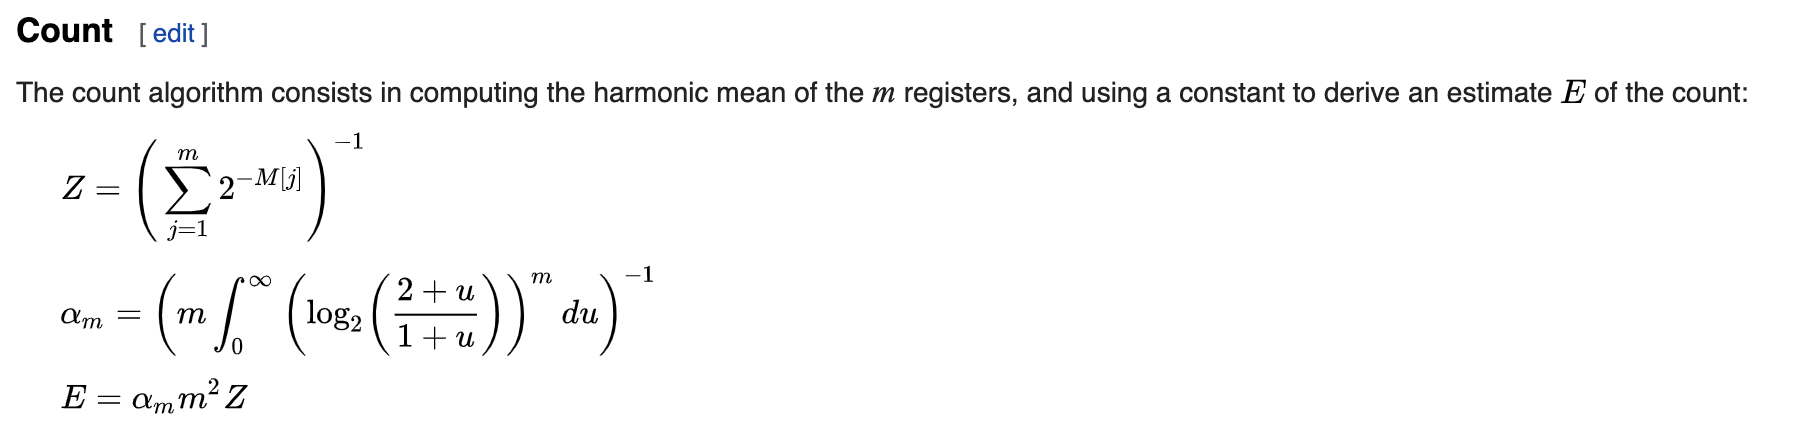

In [12]:
def hyperLogLog(stream, m=32): # m has to be power of 2
    
    # initiate an array M with m counters
    M = [0,] * (m+1) # index 0 is dummy, we only focus on index 1 to m
    
    while (True):
        
        # try getting the next element
        try:
            IP=next(stream).split()[0]
            
        # function should end here
        # enter the except block when there is no more incoming data
        except: 
            
            # get Z (note, exclude index 0 in array M)
            Z = sum(list(map(lambda x : 2**-M[x], M[1:]))) ** -1
            a_m = (quad(lambda u : math.log((2+u)/(1+u),2)**m , 0, np.inf)[0] * m)** -1
            E = a_m * (m**2) * Z

            return E
    
        # hash the IP address
        hashing=mmh3.hash(IP)
        
        # obtain a binary representation of the IP address
        binary="{0:b}".format(hashing)

        # split the binary string into upper and lower parts
        upper=binary[0: int(math.log(m,2))]
        lower=binary[int(math.log(m,2)):]

        # compute position p of the leftmost 1-bit of the lower part
        # if there is no 1 in the lower part, just return the length of the lower part
        # this is based on the fact that 0000 occurs with the same probability as 0001
        p=lower.find("1") + 1 if lower.find("1") != -1 else len(lower)

        # obtain the index j which is the integer representation of the upper part + 1
        j=abs(int(upper, 2)) + 1

        # update array M
        M[j]= max(M[j],p)
    
    return

### Q2 How many unique IPs are there for each domain?

> This is a generalization of Q1. We will modify HyperLogLog algorithm.

Our approach:

1. Maintain a dictionary where key is domain and value is a HyperLogLog array.

2. For each incoming record, update corresponding HLL array, depending on the domain.

3. Compute unique IPs for each domain. 

In [32]:
def hyperLogLog_at_scale(stream, m=32): # m has to be power of 2
    
    # initialize a domain dictionary with format {key = domain name : value = M array}
    domain_dic={}
    
    while (True):
        try:
            element=next(stream).split()
            IP=element[0]
            domain=element[1]

        except: 
            
            # init a new dictionary with format {key = domain name : value = estimated count}
            count_dic={}
            
            for (domain, M) in domain_dic.items():
                Z = sum(list(map(lambda x : 2**-M[x], M[1:]))) ** -1
                a_m = (quad(lambda u : math.log((2+u)/(1+u),2)**m , 0, np.inf)[0] * m)** -1
                E = a_m * (m**2) * Z
                
                # add the domain and its corresponding unique counts to the dictionary
                count_dic[domain]=E
                       
            return count_dic
        
        # first time seeing this domain
        # create a M array of m counters
        if domain not in domain_dic:
            domain_dic[domain] = [0,] * (m+1)
        
        # hash the IP address
        hashing=mmh3.hash(IP)
        
        # obtain a binary representation of the IP address
        binary="{0:b}".format(hashing)

        # split the binary string into upper and lower parts
        upper=binary[0: int(math.log(m,2))]
        lower=binary[int(math.log(m,2)):]

        # compute position p of the leftmost 1-bit of the lower part
        p=lower.find("1") + 1 if lower.find("1") != -1 else len(lower)

        # obtain the index j which is the integer representation of the upper part + 1
        j=abs(int(upper, 2)) + 1

        # update array M for that specific domain
        value = domain_dic[domain]
        value[j] = max(value[j],p)
        domain_dic[domain] = value
    
    # dummy return value
    return

### Q3 How many times was IP X seen on domain Y? (for some X and Y provided at run time)

> We will implement countMin data structure.

> Note: python, unlike java, does not have compile time and run time. So our group assumes the question is asking us to build countMin on each domain. Then, IP X and domain Y will be provided. If IP_X and domain_Y are provided at the start, we can simply filter and obtain the accurate frequency with the pseudo code below.

def helper(stream, IP_X, Domain_Y):
    
    counter = 0
    
    get_next_record from stream
    
    if domain == domain_Y and IP == IP_X:
        
        counter +=1
    
    return counter

Our approach:

1. Maintain a dictionary, key is domain name and value is countMin M matrix.

2. Process each record based on its domain and update corresponding M matrix.

3. Return the dictionary. 

In [37]:
def countMin(stream, w=16, d=5):
    
    # init a domain dictionary with format (key=domain name : value = M matrix)
    domain_dic={}
    
    while (True):
        
        # try getting the next IP adress
        try:
            element=next(stream).split()
            IP=element[0]
            domain=element[1]
    
        # function should end here
        except: 
            return domain_dic
        
        # create a w*d matrix for each domain
        if domain not in domain_dic:
            outer=[]
            for i in range(d):
                inner=[0,] * w
                outer.append(inner)
            # assign into dictionary
            domain_dic[domain] = outer
        
        # loop through each hashing function
        for s in range(0,d):
            # get a unique hashing
            hashing=mmh3.hash(IP, seed=s) % w

            # obtain the matrix for specified domain
            value = domain_dic[domain]
            
            # update the matrix
            value[s][hashing] +=1
            
            # assign new matrix back to the dictionary
            domain_dic[domain] = value
            
    # dummy return
    return

> Dictionary is built before run time. --> pre-compute

> IP X and Domain Y is provided at run time. --> extract estimates

In [38]:
# provide IP_X and Domain_Y at run time to extract from dictionary
def getResult(dictionary, IP_X, Domain_Y, w=16, d=5):
    Matrix=dictionary[Domain_Y]
    res_list=[]
    for s in range(0,d):
        hashing=mmh3.hash(IP_X, seed=s) % w
        res_list.append(Matrix[s][hashing])
    return min(res_list)

### Q4 How many unique IPs are there for the domains  𝑑1,𝑑2,… ?

> Our solution is based on dictionary and HyperLogLog.

> Solution to this qnestion is pretty similar to the one to question 2. If the number of domains are small, it is perfectly fine to use the solution to question 2. Our group implements the below functions with the assumption that there are too many domains in the data stream such that it is not possible to store information about each domain.

Our approach:

1. Maintain a dictionary where key is domain and value is a HyperLogLog array.

2. For each incoming record, update HLL array if the domain is in the dictionary. Else, ignore.

3. Compute unique IPs for each domain. 

In [43]:
def hyperLogLog_multiple_domains(stream, domain1, *domains, m=32): 
    # minimum number of domains to be specified: 1
    # additionally, user can specify more than 1 domain
    
    # create a domain list containing all the domains at interest
    domain_list = [domain1,]
    domain_list.extend(list(domains))
    
    # initialize a domain dictionary with format {key = domain name : value = M array}
    domain_dic={}
    
    while (True):
        try:
            element=next(stream).split()
            IP=element[0]
            domain=element[1]

        # enter the except block when there is no more incoming data
        except: 
            # init a new dictionary with format {key = domain name : value = estimated count}
            count_dic={}
            
            for (domain, M) in domain_dic.items():
                # get Z (note, exclude index 0 in array M)
                Z = sum(list(map(lambda x : 2**-M[x], M[1:]))) ** -1
                a_m = (quad(lambda u : math.log((2+u)/(1+u),2)**m , 0, np.inf)[0] * m)** -1
                E = a_m * (m**2) * Z
                # add the domain and its corresponding unique counts to the dictionary
                count_dic[domain]=E
                       
            return count_dic
        
        # if the incoming domain is of our interest, and that it is the first time we see this domain
        # create a M array of m counters
        if domain in domain_list and domain not in domain_dic:
            domain_dic[domain] = [0,] * (m+1)
        
        # hash the IP address
        hashing=mmh3.hash(IP)

        # obtain a binary representation of the IP address
        binary="{0:b}".format(hashing)

        # split the binary string into upper and lower parts
        upper=binary[0: int(math.log(m,2))]
        lower=binary[int(math.log(m,2)):]

        # compute position p of the leftmost 1-bit of the lower part
        p=lower.find("1") + 1 if lower.find("1") != -1 else len(lower)

        # obtain the index j which is the integer representation of the upper part + 1
        j=abs(int(upper, 2)) + 1

        # update array M for that specific domain
        if domain in domain_list:
            value = domain_dic[domain]
            value[j] = max(value[j],p)
            domain_dic[domain] = value
    
    # dummy return value
    return

### Q5 How many times was IP X seen on domains  𝑑1,𝑑2,… ?

> Our solution is based on dictionary and countMin.

> Solution to this qnestion is pretty similar to the one to question 3. If the number of domains are small, it is perfectly fine to use the solution to question 3. Our group implements the below functions with the assumption that there are too many domains in the data stream such that it is not possible to store information about each domain.

Our approach:

1. Maintain a dictionary with key = domain and value = countMin M matrix.

2. Process each new record based on its domain and update corresponding countMin M matrix.

3. When IP_X and domains are provided at run time, calculate the estimates from the pre-computed dictionary.

In [47]:
def countMin_multiple_domains(stream, domain_list, w, d):
        
    # initialize a domain dictionary with format (key=domain name : value = M matrix)
    domain_dic={}
    
    while (True):
        try:
            element=next(stream).split()
            IP=element[0]
            domain=element[1]
    
        # function should end here
        # enter the except block when there is no more incoming data
        except:
            # return the final dictionary
            return domain_dic
        
        # create a w*d matrix for each domain at interest
        if domain in domain_list:
            
            # first time seeing this domain
            if domain not in domain_dic:
                outer=[]
                for i in range(d):
                    inner=[0,] * w
                    outer.append(inner)
                # add the domain and its matrix to the dictionary
                domain_dic[domain] = outer
        
            # iterate through each hash function
            for s in range(0,d):
                # hash the IP address
                hashing=mmh3.hash(IP, seed=s) % w

                # obtain the current matrix for that domain
                value = domain_dic[domain]

                # increment the number of occurrences by 1 and update the matrix
                value[s][hashing] +=1

                # assign the updated matrix back to the dictionary
                domain_dic[domain] = value
            
    # dummy return value
    return

In [48]:
# makes use of the countMin_multiple_domains function
# provide IP_X and domains at runtime to extract from the dictionary obtained from the countMin_multiple_domains fucntion

def getResult_multiple_domains(stream, IP_X, domain1, *domains, w=16, d=5):
        
    # create a domain list containing all the domains at interest
    domain_list = [domain1,]
    domain_list.extend(domains)
    
    # obtain the countMin_dic from countMin_multiple_domains()
    countMin_Dic = countMin_multiple_domains(stream, domain_list, w, d)
    
    # initialize a dictionary to store the number of times IP X is seen on different domains
    # {domain1:n times, domain2: m times, ...}
    res_dic = {}
    
    # iterate through the domain list
    for domain in domain_list:  
    
        # obtain the frequency matrix for a particular domain
        Matrix=countMin_Dic[domain]

        # initialize a list to store the all the estimated numbers of occurrences from d hashing functions
        res_list=[]
        
        for s in range(0,d):
            hashing=mmh3.hash(IP_X, seed=s) % w
            res_list.append(Matrix[s][hashing])
            count = min(res_list)
            # add the count for this particular domain to res_dic
            res_dic[domain] = count
    
    return res_dic

### Q6 What are the X most frequent IPs in the stream?

#### <font color = "blue"> As requested, we will implement the data structure taught in the class. However, it <font color='red'> DOES NOT </font> solve the problem. </font>

> Finding the top X most frequent IPs is an extension of finding the most frequent IP. 

> Our group will modify the Boyer–Moore majority vote algorithm. Source: https://en.wikipedia.org/wiki/Boyer%E2%80%93Moore_majority_vote_algorithm

Our approach :

1. Maintain a dictionary of size X. Key is IP and value is corresponding frequency.

2. For each new record e, if e is in the dictionary, increment the frequency by 1.

3. If e is not in the dictionary and the dictionary size is smaller than X, add e to the dictionary with frequency being 1.

4. If the dictionary size is X, then decrement all frequencies by 1.

5. Remove the key-value pair from the dictionary if the value becomes 0.

In [75]:
def majority_voting_modified(stream, X):
    # initiate a dictionary with format {key = IP : value = freqency}
    topX = {}
    
    while (True):
        # getting next IP
        try:
            IP = next(stream).split("\t")[0]
        
        # when no more incoming record
        except:
            return topX
        
        # Case 1 : IP in the dictionary
        if IP in topX:
            topX[IP] += 1
        
        # Case 2: IP not in dictionary
        else:
            
            # Case 2a : topX has vacancy
            if len(topX) < X:
                topX[IP] = 1
                
            # Case 2b: topX does not have vacancy
            else:
                remove=[]
                for key in topX:
                    topX[key] -= 1
                    if topX[key] == 0:
                        remove.append(key)
                        
                # remove key-value pair with value == 0
                for rm in remove:
                    topX.pop(rm)
        print(topX)
    
    return

In [76]:
STREAM_SIZE = 100
web_traffic_stream = stream(STREAM_SIZE)

In [77]:
majority_voting_modified(web_traffic_stream, 5)

{'186.99.192.116': 1}
{'186.99.192.116': 1, '202.152.82.171': 1}
{'186.99.192.116': 1, '202.152.82.171': 1, '130.126.231.205': 1}
{'186.99.192.116': 1, '202.152.82.171': 1, '130.126.231.205': 1, '116.142.112.214': 1}
{'186.99.192.116': 1, '202.152.82.171': 1, '130.126.231.205': 1, '116.142.112.214': 1, '113.124.204.127': 1}
{}
{'138.74.228.219': 1}
{'138.74.228.219': 1, '56.120.106.87': 1}
{'138.74.228.219': 1, '56.120.106.87': 1, '189.119.55.225': 1}
{'138.74.228.219': 1, '56.120.106.87': 1, '189.119.55.225': 1, '180.110.73.101': 1}
{'138.74.228.219': 1, '56.120.106.87': 1, '189.119.55.225': 1, '180.110.73.101': 1, '125.147.103.124': 1}
{}
{'64.108.133.139': 1}
{'64.108.133.139': 1, '87.91.133.89': 1}
{'64.108.133.139': 1, '87.91.133.89': 1, '111.141.147.118': 1}
{'64.108.133.139': 1, '87.91.133.89': 1, '111.141.147.118': 1, '97.65.99.76': 1}
{'64.108.133.139': 1, '87.91.133.89': 1, '111.141.147.118': 1, '97.65.99.76': 1, '80.99.56.157': 1}
{}
{'200.132.86.152': 1}
{'200.132.86.152': 

{'208.114.96.119': 1,
 '114.255.47.190': 1,
 '175.132.133.122': 1,
 '52.30.199.124': 1}

> As we can see from the result, it does not fulfill our requirement which is to return the most frequent IPs. 

> This is because the frequencies of IPs, even for the most frequent ones, are very low. Hence, IPs are removed from dictionary become they appear for the second time. i.e. After every k loops, the dictionary will be empty.

<font color='blue'> Therefore, we have to implement our own data structure which has worse space complexity but will be able to return the desired answer. </font>

Our approach:

1. Maintain a countMin M matrix to store frequency of each IP.

2. Maintain a dictionary with key = frequency and value = list of IPs. Dictionary size is at maximum X.

3. For each new record
    
    3.1 update M matrix
    
    3.2 extract its frequency
    
    3.3 update dictionary (see details below)
    
        add_single_IP_to_dic():
           if    IP exists in any key-value pair --> remove from list of IPs
         
           if    frequency is not in the dictionary --> create a new key-value pair
           else  add IP to the corresponding key-value pair
        
        update_dictionary():
            if dictionary size < X:
                add_single_IP_to_dic()
            else
               minF = minimum frequency stored in the dictionary
               if    frequency > minF --> remove minF key-value pair
                                      --> add_single_IP_to_dic()
               if    frequency == minF --> add_single_IP_to_dic()
                                  
        

4. Settle ties. There may be more than one IPs with the same frequency. When return top X, consider all IPs with the same frequency if they are in top X.

In [53]:
# topX_dic is a dictionary of the following format: 
# {frequency1 : [IP1, IP2, ...], frequency2 : [IP3, IP4, ...], ...}
# The maximum dictionary size is X. This happens when each frequency corresponds to one and only one IP.
def add_to_topX_dic(topX_dic, IP, count):    
    
    # firstly, iterate through the dictionary to find if this IP already exists
    for freq, IPs in topX_dic.items():
        
        # remove the IP from its old count key if it exists
        if IP in IPs:
            IPs.remove(IP)
            topX_dic[freq] = IPs
    
    # if it is the first time this count is seen in the dictionary, create a key-value pair straightaway
    if count not in topX_dic:
        topX_dic[count] = [IP,]
    
    # if this count already exists in the dictionary
    else:
        # add IP as a value of its new count key in the dictionary
        lst = topX_dic[count]
        lst.append(IP)
        topX_dic[count] = lst
    
    return topX_dic
    
    
    
# define a function to check whether we should put an IP into the topX dictionary, and do so when necessary
def update_topX_dic(topX_dic, IP, count, X):
        
    # if topX_dic is not fully filled (fewer than X pairs)
    if len(topX_dic) < X:
        # add this IP to topX_dic
        topX_dic = add_to_topX_dic(topX_dic, IP, count)
    
    else:
        # sort the current top frequencies in ascending order
        top_frequencies = sorted(list(topX_dic.keys()))
        
        # find the current minimum frequency accepted by the topX dictionary
        min_freq = top_frequencies[0]
        
        # if the count is greater than min_freq, add this item to topX_dictionary
        # delete the key-value pair with the min_freq
        if count > min_freq:
            topX_dic = add_to_topX_dic(topX_dic, IP, count)
            topX_dic.pop(min_freq)
            
        # if the count is equal to min_freq, add this item to topX_dictionary, but do not delete the min_freq key-value pair
        if count == min_freq:
            topX_dic = add_to_topX_dic(topX_dic, IP, count)
    
    return topX_dic
 
    
# a tie occurs when the last few most frequent IPs have the same frequency
# e.g. X = 10; both the 10th and the 11th IP in the top X list have the same frequency. In such cases, we will include both
# therefore, the actual number of IPs in the top X list may exceed X.
def settle_ties(topX_dic, X):
    
    # initialize a counter to keep track of the total number of IPs in the top X list
    counter = 0
    
    # initialize a list that stores the top X most frequent counts and their IPs
    # [(IP1, frequency1), (IP2, frequency2), ...]
    topX_list = []
    
    # obtain the sorted frequencies in the dictionary in descending order
    sorted_frequencies = sorted(topX_dic.keys(), reverse = True)
    
    for freq in sorted_frequencies:
        # if no IPs have been added to topX_list, at least add the first set of IPs to the list
        if counter == 0:
            for IP in topX_dic[freq]:
                topX_list.append((IP, freq))
            # increment the counter by the number of IPs
            counter += len(topX_dic[freq]) 
        
        # if after adding the previous IPs to the list, len(topX_list) equals to X exactly, escape the for loop
        elif counter == X:
            break
        
        # if adding IPs with this frequency to the topX list does not make the length go beyond X, add these to the list 
        elif counter + len(topX_dic[freq]) < X:
            for IP in topX_dic[freq]:
                topX_list.append((IP, freq))
            # increment the counter by the number of IPs
            counter += len(topX_dic[freq]) 
        
        # else settle ties by add the IPs, then escape the for loop
        else:
            for IP in topX_dic[freq]:
                topX_list.append((IP, freq))
            break
        
    # sort the topX list in descending order of counts
    topX_list.sort(key=lambda tup: tup[1], reverse=True)
    
    # return the topX IPs and their counts in the form of a dictionary
    return dict(topX_list)

In [54]:
def topX_frequency(stream, X, w=32, d=10):
    
    M=[]
    for i in range(d):
        inner=[0,] * w
        M.append(inner)
    
    # initialize a dictionary to store the top frequencies and also settle ties (if any)
    # {frequency1 : [IP1, IP2, ...], frequency2 : [IP3, IP4, ...], ...}
    topX_dic = {}    
    
    while (True):
        
        # try getting the next element
        try:
            element=next(stream).split()
            IP=element[0]
    
        # function should end here
        # enter the except block when there is no more incoming data
        except:
            final_topX = settle_ties(topX_dic, X)
            return list(final_topX.keys())
        
        frequency_list=[]
        # update M matrix
        for s in range(0,d):
            # hash the IP address
            hashing=mmh3.hash(IP, seed=s) % w
            M[s][hashing] +=1
            frequency_list.append(M[s][hashing])
        
        
        # find the current estimate of the number of occurrences of an IP address
        count = min(frequency_list)
        
        # check and update the topX dictionary accordingly
        topX_dic = update_topX_dic(topX_dic, IP, count, X)
    
    # dummy return value
    return None

> Additionally, we would like to propose another method to find the top X most frequent IPs. 

>We would like to do a reservoir smapling. According to law of probability, the frequency of an IP in the sample should be able to reflect its frequency in the whole stream data.

In [112]:
def reservoir_sampling(stream, k, X):
    
    # keep a counter for total number of records
    count = 0
       
    # Initialize the reservoir array with size k, index [0, k-1]
    reservoir = [" "] * k
    
    # Fill the reservoir array by the first k elements from streaming data
    while count < k: 
        IP = next(stream).split("\t")[0]
        reservoir[count] = IP # fill one slot in reservoir array
        count += 1
    
    # Iterate all incoming streaming elements
    while (True):
        # get the next incoming element
        try:
            IP = next(stream).split("\t")[0]
        # finish processing all streaming data
        except:
            res=sorted(list(dict(Counter(reservoir)).items()), 
                       key= lambda x : x[1], 
                       reverse=True)
            return res[:X]
        

        if k < random.randrange(count + 1):
            # replace a slot in reservoir array selected uniformly at random
            reservoir[random.randrange(k)] = IP
            
    return None

## Analysis

### Accuracy Analysis

In [35]:
def find_exact_counts(stream):
    
    # initialize a dictionary of dictionaries that stores the exact counts for each IP for each domain
    # {domain1 : {IP1 : occurrences1, IP2 : occurrences2, ...}, domain2: {IP1 : occurrences1, ...}, ...}
    exact_dic = {}
    
    while (True):
        
        # try getting the next element
        try:
            element=next(stream).split()
            IP=element[0]
            domain=element[1]
        
        # function should end here
        # enter the except block when there is no more incoming data
        except:
            return exact_dic
        
        if domain not in exact_dic.keys():
            exact_dic[domain] = {}
            exact_dic[domain][IP] = 1
        
        else:
            sub_dic = exact_dic[domain]
            if IP not in sub_dic.keys():
                sub_dic[IP] = 1
            else:
                sub_dic[IP] += 1
            # replace the original sub_dic by the updated one
            exact_dic[domain] = sub_dic

    # dummy return value    
    return None

> Our approach is to get the exact answers for each algorithm and compare it with the estimates. We will provide some qualitative explanation as much as possible.

### Q1 How many unique IPs are there in the stream?

In [30]:
# estimates
STREAM_SIZE = 1000
web_traffic_stream = stream(STREAM_SIZE)
distinct_count = hyperLogLog(web_traffic_stream)
distinct_count

28.4032508105588

In [31]:
# exact
def unique_IP(stream):
    dic={}
    while (True):
        try:
            IP=next(stream).split("\t")[0]
        except:
            return len(dic)
        
        if IP not in dic:
            dic[IP] = 0
    return

STREAM_SIZE = 1000
web_traffic_stream = stream(STREAM_SIZE)
unique_IP(web_traffic_stream)

1000

> The estimated answer is 28 while the true answer is 1000. There is a huge discrepancy. Our group feel it is because the HyperLogLog algorithm does not work well when every IP appear once and only once. HyperLogLog relies on hashing to differentiate IPs. If all IPs are unique, hashing will fail because our HyperLogLog array size is limited, in our case, 32. 

### Q2 How many unique IPs are there for each domain?

In [33]:
# estimates
STREAM_SIZE = 1000
web_traffic_stream = stream(STREAM_SIZE)
hyperLogLog_at_scale(web_traffic_stream)

{'python.org': 23.74564913138453,
 'wikipedia.org': 24.52315025699615,
 'pandas.pydata.org': 23.574111934356978,
 'dtu.dk': 22.30792428163273,
 'google.com': 22.30792428163273,
 'databricks.com': 22.30792428163273,
 'github.com': 22.30792428163273,
 'spark.apache.org': 22.30792428163273,
 'datarobot.com': 22.30792428163273}

In [36]:
# exact
STREAM_SIZE = 1000
web_traffic_stream = stream(STREAM_SIZE)
exact_counts_dic = find_exact_counts(web_traffic_stream)
exact_res={}
for (k,v) in exact_counts_dic.items():
    exact_res[k] = len(v)
exact_res

{'python.org': 281,
 'wikipedia.org': 510,
 'pandas.pydata.org': 129,
 'dtu.dk': 24,
 'google.com': 25,
 'databricks.com': 10,
 'github.com': 14,
 'spark.apache.org': 6,
 'datarobot.com': 1}

> Estimates for some domains are accurate such as dtu.dk, google.com. Others are not accurate. We suspect that those which are accurate are coincidences, because seems that estimate for every domain is around 22-24.

### Q3 How many times was IP X seen on domain Y? (for some X and Y provided at run time)

In [39]:
# estimates
STREAM_SIZE = 1000
web_traffic_stream = stream(STREAM_SIZE)
countMin_Dic=countMin(web_traffic_stream)
getResult(countMin_Dic, "202.152.82.171", "wikipedia.org" )

24

In [41]:
# exact
STREAM_SIZE = 1000
web_traffic_stream = stream(STREAM_SIZE)
exact_counts_dic = find_exact_counts(web_traffic_stream)
exact_counts_dic["wikipedia.org"]["202.152.82.171"]

1

> countMin is an over-estimate for the frequency. This is expected because over-estimation is inevitable for the countMin algorithm.

### Q4 How many unique IPs are there for the domains  𝑑1,𝑑2,… ?

In [44]:
# estimates
STREAM_SIZE = 1000
web_traffic_stream = stream(STREAM_SIZE)
hyperLogLog_multiple_domains(web_traffic_stream, 
                             "pandas.pydata.org", 
                             "python.org", 
                             "wikipedia.org")

{'python.org': 23.74564913138453,
 'wikipedia.org': 24.52315025699615,
 'pandas.pydata.org': 23.574111934356978}

In [45]:
# exact
STREAM_SIZE = 1000
web_traffic_stream = stream(STREAM_SIZE)
exact_counts_dic = find_exact_counts(web_traffic_stream)
exact_dic={}
exact_dic['python.org'] = len(exact_counts_dic["python.org"])
exact_dic['wikipedia.org'] = len(exact_counts_dic['wikipedia.org'])
exact_dic['pandas.pydata.org'] = len(exact_counts_dic['pandas.pydata.org'])
exact_dic

{'python.org': 281, 'wikipedia.org': 510, 'pandas.pydata.org': 129}

> Again, HyperLogLog seems to give wrong estimates.

### Q5 How many times was IP X seen on domains  𝑑1,𝑑2,… ?

In [51]:
# estimates
STREAM_SIZE = 1000
web_traffic_stream = stream(STREAM_SIZE)
results_dictionary = getResult_multiple_domains(web_traffic_stream,
                                                "186.99.192.116", 
                                                "python.org", 
                                                "wikipedia.org")
results_dictionary

{'python.org': 18, 'wikipedia.org': 27}

In [52]:
# exact
STREAM_SIZE = 1000
web_traffic_stream = stream(STREAM_SIZE)
exact_counts_dic = find_exact_counts(web_traffic_stream)
exact_dic={}
exact_dic["python.org"]=exact_counts_dic["python.org"]["186.99.192.116"]
exact_dic["wikipedia.org"]=exact_counts_dic["wikipedia.org"]["186.99.192.116"]
exact_dic

KeyError: '186.99.192.116'

> There is an keyError when getting the exact count, meaning that in the first 1000 records, IP '186.99.192.116' does not even appear. However, estimates are available. This means estimates are not accurate.

### Q6 What are the X most frequent IPs in the stream?

In [55]:
# estimates
STREAM_SIZE = 1000
web_traffic_stream = stream(STREAM_SIZE)
topX = topX_frequency(web_traffic_stream, 3)
topX

['174.83.136.188', '111.124.49.168', '128.187.104.68', '155.206.241.132']

In [73]:
# exact
def most_frequent(stream,X):
    topX={}
    while (True):
        try:
            IP=next(stream).split("\t")[0]
        except:
            sort= sorted(list(topX.items()), 
                          key=lambda x : x[1],
                          reverse=True)
            return list(map(lambda x : x[0], sort[:X]))

        if IP not in topX:
            topX[IP] = 0
        topX[IP] += 1
    return

In [74]:
STREAM_SIZE = 1000
web_traffic_stream = stream(STREAM_SIZE)
most_frequent(web_traffic_stream, 3)

['186.99.192.116', '202.152.82.171', '130.126.231.205']

> Seems the estimates for topX is not accurate either.

In [77]:
# check the accuracy of IP counting
def CountIP_accuracy(stream): 
    #create a dictionary(key is IP,value is count)
    IP_dict={}
    
    element=next(stream).split()
    IP=element[0]
    domain=element[1]
      
    for count in stream: 
        if (count in IP_dict): 
            IP_dict[count] += 1
        else: 
            IP_dict[count] = 1
  
    for IP, count in IP_dict.counts(): 
        print ("% d : % d"%(IP, count)) 
        return IP_dict

In [78]:
#check the accuracy of CountMin function
def CountMin_accuracy(stream):
    #create a dictionary (key is domain, value is IP_dict)
    domain_dict={}
    
    element=next(stream).split()
    IP=element[0]
    domain=element[1]
    
    for IP_dict in stream:
        if (IP_dict in domain_dict): 
            domain_dict[IP_dict] += 1
        else: 
            domain_dict[IP_dict] = 1
  
    for domain, IP_dict in IP_dict.counts(): 
        print ("% d : % d"%(domain, IP_dict)) 